In [66]:
%matplotlib inline
import matplotlib
import pandas as pd # package for data analysis, reading in the data, summarizing data, manipulating data
import numpy as np # package for math operations
import matplotlib.pyplot as plt # package for plotting
from IPython.display import Image
import itertools
from sklearn import preprocessing, metrics, model_selection, linear_model, ensemble, svm

In [164]:
# read in the data
X = pd.read_csv('hubway_data_subset.csv', index_col=0)
X.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,age,check_out_hour,g1,g2,g3
0,1,8,Closed,9.0,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,1,'97217,1976.0,1,35.0,10,0.0,1.0,0.0
1,2,9,Closed,220.0,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,1,'02215,1966.0,1,45.0,10,0.0,1.0,0.0
2,3,10,Closed,56.0,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,1,'02108,1943.0,1,68.0,10,0.0,1.0,0.0
3,4,11,Closed,64.0,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,1,'02116,1981.0,0,30.0,10,1.0,0.0,0.0
4,5,12,Closed,12.0,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,1,'97214,1983.0,0,28.0,10,1.0,0.0,0.0


# MODEL EVALUATION
* How well is my model doing - Receiver operating characteristic (ROC) curve
* Over-fitting
* How to choose model parameters - cross validation
* How to choose model class

# Dataset - Hubway Bike Rentals
* Bike trips taken with variety of metrics collected on the trip
* Classification task: classify each bike trip as taken by Registered vs. Casual user

In [112]:
le = preprocessing.LabelEncoder() # specify paramets for encoder
X['subsc_type'] = le.fit_transform(X['subsc_type']) # fit the model and transform the gender variable
# test and train split
# we will be using just two features for our task
X_train, X_test, y_train, y_test = model_selection.train_test_split(X[['duration', 'check_out_hour']], X['subsc_type'], test_size=0.2, random_state=1)

In [113]:
# standardize the features
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# METRICS
* Area under ROC curve (AUC)
* Confusion matrix
* For Kaggle competitions: note the metric you are evaluated on and optimize the performance on that specific metric!

# Receiver operating characteristic (ROC) curve
* Diagnostic ability of classifier
* Plots true positive rate (TPR) against the false positive rate (FPR) at various threshold settings
$$TPR = \frac{TP}{TP + FN}$$
$$FPR = \frac{FP}{FP + TN}$$
* Area under the ROC curve (AUC) - single number which reflects model's performance 

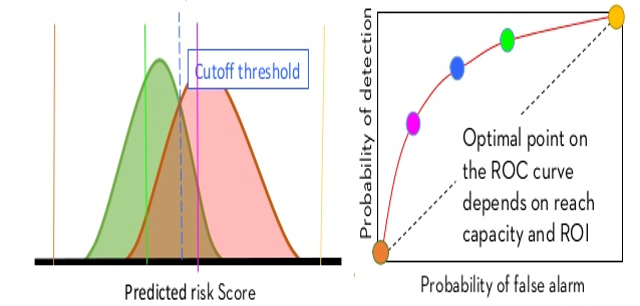

In [153]:
Image(filename='images/roc_thresholds.png', width = 500, height = 100)

Let's train model (SVM) and evalute its performance using ROC curve

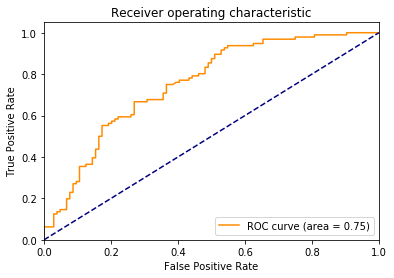

In [114]:
clf = svm.SVC()
clf.fit(X_train, y_train)
# obtain the learned decision function and evaluate it on the held-out data
y_pred_scores = clf.decision_function(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_scores) # obtain false positive and true positive rates
area_under_curve = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % area_under_curve) # plot ROC curve
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Confusion matrix

Text(0.5,0,'Predicted label')

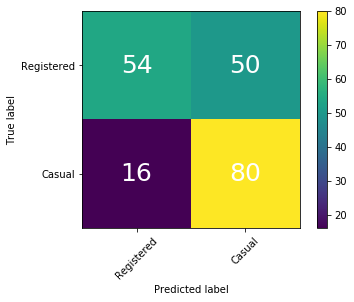

In [146]:
y_pred = clf.predict(X_test) # predict class labels
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) # obtain confusion matrix
plt.imshow(cnf_matrix) # plot the matrix
plt.colorbar()
plt.xticks([0, 1], ['Registered', 'Casual'], rotation=45)
plt.yticks([0, 1], ['Registered', 'Casual'])
width, height = cnf_matrix.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cnf_matrix[x][y]), xy=(y, x), 
                    horizontalalignment='center', verticalalignment='center', color="white", fontsize = 25)    
plt.ylabel('True label')
plt.xlabel('Predicted label')

#  Over-fitting and trade-off between model complexity
* Model that corresponds too closely or exactly to a particular set of data
* As a result model doesn't generalize well to additional data or predict future observations reliably
* Important for Kaggle competitions and machine learning in general

In [157]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/300px-Overfitting.svg.png',  width = 300, height = 300)

Let's fit a model, specifying parameters, and see if it over-fits. If the performance on the test (unseen data) is much worse than the performance on the training data, then there is over-fitting.
For SVM (support vector machine) classifier, two parameters can be specified that affect complexity of the model:
* The C parameter trades off misclassification of training examples against simplicity of the decision surface
* Low C makes the decision surface smooth
* High C aims at classifying all training examples correctly
* The gamma parameter defines how far the influence of a single training example reaches
* Low values meaning far and high values meaning close

In [117]:
clf_not_overfitted = svm.SVC(C=1, gamma=0.5)
clf_not_overfitted.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [118]:
y_pred_scores_train = clf_not_overfitted.decision_function(X_train)
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_scores_train) # obtain false positive and true positive rates
area_under_curve_train = metrics.auc(fpr_train, tpr_train) # AUC
print('AUC evaluated on training data = %0.2f' % area_under_curve_train)

y_pred_scores_test = clf_not_overfitted.decision_function(X_test)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_scores_test) # obtain false positive and true positive rates
area_under_curve_test = metrics.auc(fpr_test, tpr_test) # AUC
print('AUC evaluated on test data = %0.2f' % area_under_curve_test)

AUC evaluated on training data = 0.75
AUC evaluated on test data = 0.75


Here AUC on training and test data are about the same, so there is likely no over-fitting.

Let's fit the same classifier (SVM) but with different model parameters and see if there is over-fitting. High C and gamma parameters are likely to result in over-fitting.

In [121]:
clf_overfitted = svm.SVC(C=100000, gamma=10)
clf_overfitted.fit(X_train, y_train)

SVC(C=100000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [122]:
y_pred_scores_train = clf_overfitted.decision_function(X_train)
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_scores_train) # obtain false positive and true positive rates
area_under_curve_train = metrics.auc(fpr_train, tpr_train) # AUC
print('AUC evaluated on training data = %0.2f' % area_under_curve_train)

y_pred_scores_test = clf_overfitted.decision_function(X_test)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_scores_test) # obtain false positive and true positive rates
area_under_curve_test = metrics.auc(fpr_test, tpr_test) # AUC
print('AUC evaluated on test data = %0.2f' % area_under_curve_test)

AUC evaluated on training data = 0.84
AUC evaluated on test data = 0.71


Here AUC on training data is much better than on test data, meaning that the model with these tuning parameters does not generalize well to unseen test data, so there is over-fitting.

# Cross validation
* Assess how the model will generalize to an independent dataset
* Helps avoid over-fitting
* Aids in choosing model tuning parameters such as the penalty parameters C and gamma in SVM

1. Split data into training, validation and test sets
2. Use **training set** to learn models under different tuning paramters ($\lambda$)
3. Check the performance of each model (for example by calculating AUC) on the **validation set**
4. Choose model and associated tuning parameters that give highest performance on the **validation set**
5. Evaluate the final generalization error of the model on the **test set**

# K-fold cross validation
* Using a single validation set might be problematic
* Could be overfitting on that validation set
* Evaluate each model on **multiple** validation sets
* However, drawing multiple training and validation sets randomly might mean that samples will appear only in training or only in validation sets
* Solution: K-fold cross validation - splits data into $K$ uniformly sized chunks
* Use $K-1$ chunks for training and the remaining chunk for validation
* All observations are used for both training and validation
* Each observation is used for validation exactly once
* 5-fold cross validation and 10-fold cross validation are most common
* Cross-validation error: model performance averaged over $K$ folds $$CV(\lambda) = \frac{1}{K}\sum_{k=1}^K E_k(\lambda)$$

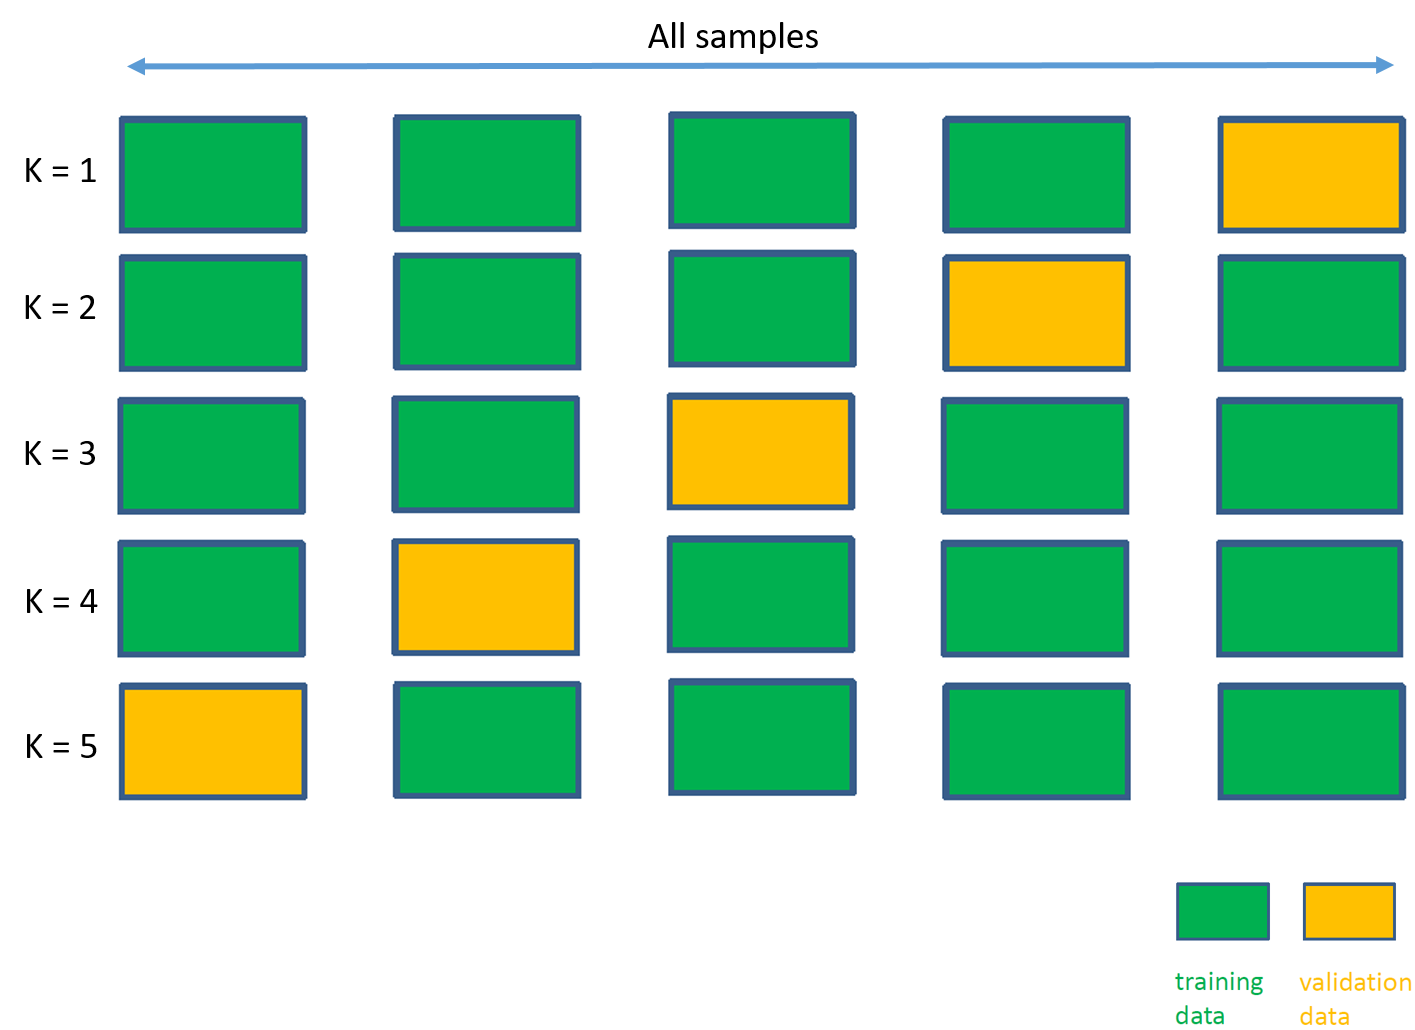

In [166]:
Image(filename='images/kfold.png', width = 800, height = 600)

We will fit several SVM classifiers with different C and gamma parameters. Each classifier will be evaluated using 5-fold cross validation. Performance will be measured using AUC.

In [139]:
# this will probably take a long time to run
C_range = np.logspace(-2, 10, 5) # choose the parameter range for C
gamma_range = np.logspace(-9, 3, 5) # choose the parameter range for gamma
param_grid = dict(gamma=gamma_range, C=C_range)
cv = model_selection.KFold(n_splits=5) # choose 5-fold cross validation
grid = model_selection.GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, scoring = 'roc_auc', verbose=1) # evaluate every combo
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
The best parameters are {'C': 10000.0, 'gamma': 0.001} with a score of 0.75


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 99.8min finished


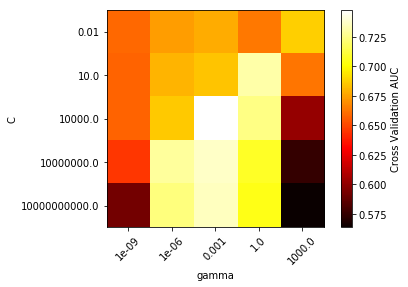

In [156]:
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
cbar = plt.colorbar()
cbar.set_label('Cross Validation AUC')

What is the performance of the chosen model on the **test set**?

In [162]:
clf = svm.SVC(C = grid.best_params_['C'], gamma = grid.best_params_['gamma'])
clf.fit(X_train, y_train)
# obtain the learned decision function and evaluate it on the held-out data
y_pred_scores = clf.decision_function(X_test)
# obtain false positive and true positive rates
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_scores)
area_under_curve = metrics.auc(fpr, tpr)
print('AUC evaluated on test data = %0.2f' % area_under_curve)

AUC evaluated on test data = 0.74


# Choosing Model Classes
* How to choose which model class to use
* Logistic regression, SVM, Random forest, neural net
* Depends on what you want to do with a model afterwards
* Best prediction performance
* Interpretability of learned model parameters
* Uncertainty estimates/confidence intervals

In [140]:
Image(url='http://scikit-learn.org/stable/_static/ml_map.png', width = 800, height = 500)

## Schedule
- **5:00pm-6:00pm** Dinner and Team Formation
- **6:00pm-8:30pm** Datathon
  - Register your team
  - Download the data
  - Perform exploratory data analysis
  - Implement simple models
  
- **9:00pm-9:30pm** Teams progress report
   - Each team gives a 5 minute report. Highlight important processes, insights and conclusions. 
   - Make at least 1 slide. 